In [402]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import pandas as pd
pynt=True
if pynt:
    import pynt
    pynt.set_style('pynt')
    pynt.set_fontsize(12)

# Global variables
operations=np.array(["[0]NOT", "[1]NAND", "[2]AND", "[3]ORN", "[4]OR", "[5]ANDN", "[6]NOR", "[7]XOR", "[8]EQU"])
Phi_0=np.array([1,1,2,2,3,3,4,4,5])

## Instructions
- Data from avida run saves automatically in "./cbuild/work/data/AGIdata/run". It consists of three csv files and a folder: "settings.csv", "metarun.csv" and "chromosomes.csv". The latter is only used for the run itself. The folder is called "meta" and it itself consists of folders "M0", "M1", "M2" and so on. These in turn consist of csv files with names "N0.csv", "N1.csv", "N2.csv" and so on. These contain data for the updates for every world. 
- If you want to save the "run" folder change the name to something so it won't be overwritten. The following functions uses the "run" folder per default but pass another name in the variable "run_name" to change this.

### Helper functions
- read data
- plot update data
- compare update data
- plot meta data
- produce report with settings and meta data

In [403]:
def read_update_data(M, N, chromosome_length=9, run_name="run"):
    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)
    update=data[:,0]
    gen=data[:,1]
    phi_i=data[:,2]
    phi_0=data[:,3]
    n_orgs=data[:,4]
    tasks = np.array([data[:,i] for i in range(5,5+chromosome_length)])
    update_data = {"updates": update, "generation": gen, "phi_i":phi_i, "phi_0":phi_0, "n_orgs": n_orgs, "tasks": tasks}
    return update_data

In [404]:
def plot_update_data(M, N, ax, flag=0, prints=True, run_name="run"):
    data = read_update_data(M, N, run_name=run_name)
    if flag==0:
        #plot phi_0
        ax.plot(data["updates"], data["phi_0"], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel="Fitness", yscale='log')
        ax.legend()
        temp = data['phi_0']
        print(f"(m,n)=({M},{N}): Sum of phi_0: {np.sum(temp): .2g}, Phi_0 at last update {temp[-1]} " )
    elif flag==1:
        #plot tasks
        for j in range(len(data["tasks"])):
            ax.plot(data["updates"], data["tasks"][j]/data["n_orgs"], label=f"{operations[j]}")
        ax.legend(ncol=2)
        ax.set(xlabel="updates", ylabel="Fraction of population", title=f"(m,n)=({M},{N})", ylim=[0,1])
        temp=data["tasks"]
        print(f"(m,n)=({M},{N}): Sum of tasks: {np.sum(np.sum(temp,axis=1)): .2g},\n {np.sum(temp,axis=1):}")
    elif flag==2:
        #plot phi_0 sum
        phi_0_cum_sum = [0]
        for i, phi_0_u in enumerate(data["phi_0"]):
            phi_0_cum_sum.append(phi_0_cum_sum[-1] + phi_0_u)
        ax.plot(data["updates"], phi_0_cum_sum[1:], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel=r"Cumulative sum of $\Phi_0$", yscale="log")
        ax.legend()

In [405]:
def read_meta_data(chromosome_length, run_name="run"):
    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/metarun.csv", delimiter=',', skip_header=1)
    m=data[:,0]
    phi_0_max=data[:,1]
    hat_phi = np.array([data[:,i] for i in range(2,2+chromosome_length)])
    meta_data = {"m":m, "phi_0_max":phi_0_max, "chromosome":hat_phi }
    return meta_data

In [406]:
def plot_meta_data(ax, flag=0, task=0, run_name="run"):
    data = read_meta_data(9, run_name=run_name)
    if flag==0:
        ax.plot(data['m'], data['phi_0_max'])
        ax.set(xlabel='Meta Generation', ylabel=r"Max fitness $\Phi_0$", yscale='log')
    if flag==1:
        ax.plot(data['m'], data['chromosome'][task])
        ax.set(ylabel="chromosome", title=f"Task {task}", xlabel=r'$m$')

In [407]:
def compare_meta_runs(M=[0,1,2], N=[0,0,0], run_name="run"):
    if len(M) != len(N):
        print("Not same length of N and M")
        return False
    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M)+1, 2, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    for i in range(1,len(M)+1):
        axs.append(fig.add_subplot(gs[i, :]))
    
    for i, m, n in zip(range(2, len(M)+2), M, N):
        plot_update_data(m, n, axs[0], flag=0, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[1], flag=2, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[i], flag=1, prints=True, run_name=run_name)
        

In [408]:
def plot_final_genome(ax, run_name="run"):
    data = read_meta_data(chromosome_length=9, run_name=run_name)
    final_chromosome = np.array([d[-1] for d in data['chromosome']])
    ax.plot(operations, final_chromosome)
    ax.set(xlabel="Operations", ylabel="Bonus", title="Final Chromosome")

In [409]:
def decay(m, decay_rate=0.95, constant=25/3, min_constant=0.5):
    return constant*decay_rate**m + min_constant

In [410]:
def read_settings_data(run_name="run"):
    df = pd.read_csv(f"./cbuild/work/data/AGIdata/{run_name}/settings.csv")
    return df

In [411]:
def produce_meta_report(run_name="run"):
    print("***** REPORT *****")
    
    print("Settings:")
    df = read_settings_data(run_name=run_name)
    display(df)
    gene_min=df[' gene_min'][0]; gene_max=df[' gene_max'][0]
    
    fig1, axs = plt.subplots(1,2, figsize=(8,2))
    m = np.linspace(0, df['M'])
    ax=axs[0]
    ax.plot(m, decay(m, decay_rate=df[' mutation_decay'][0], constant=df[' mutation_probability_constant'][0], min_constant=df[' min_mutation_constant'][0])/9)
    ax.set(ylabel="Mutation probability", xlabel=r'$m$')
    ax=axs[1]
    ax.plot(m, decay(m, decay_rate=df[' creep_decay'][0], constant=df[' creep_probability'][0], min_constant=df[' min_creep'][0]))
    ax.set(ylabel="Creep rate", xlabel=r'$m$')
    
    print("Best fintess per meta generation and the corresponding chromosomes")
    fig2 = plt.figure(constrained_layout=True, figsize=(16,12))
    gs = GridSpec(5, 3, figure=fig2)
    axs = [fig2.add_subplot(gs[0, :])]
    for i in range(1,4):
        for j in range(3):
            axs.append(fig2.add_subplot(gs[i, j]))
    axs.append(fig2.add_subplot(gs[4,:]))
            
    plot_meta_data(axs[0], flag=0, run_name=run_name)
    for task, ax in enumerate(axs[1:1+9]):
        plot_meta_data(ax, flag=1, task=task, run_name=run_name)
        ax.set(ylim=[gene_min, gene_max])
    plot_final_genome(axs[-1], run_name)
    

***** REPORT *****
Settings:


,N,M,U,tournament_probability,crossover_probability,mutation_probability,mutation_probability_constant,mutation_decay,min_mutation_constant,gene_min,...,min_creep,hatPhi_0[0],hatPhi_0[1],hatPhi_0[2],hatPhi_0[3],hatPhi_0[4],hatPhi_0[5],hatPhi_0[6],hatPhi_0[7],hatPhi_0[8]
0,12,200,1000,0.8,0.3,0.222222,2.0,0.95,0.5,0.0,...,0.5,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,5.0


Best fintess per meta generation and the corresponding chromosomes


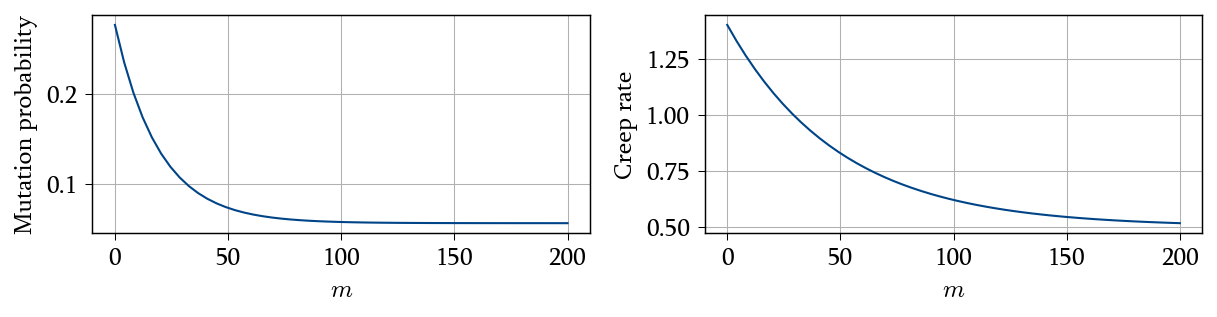

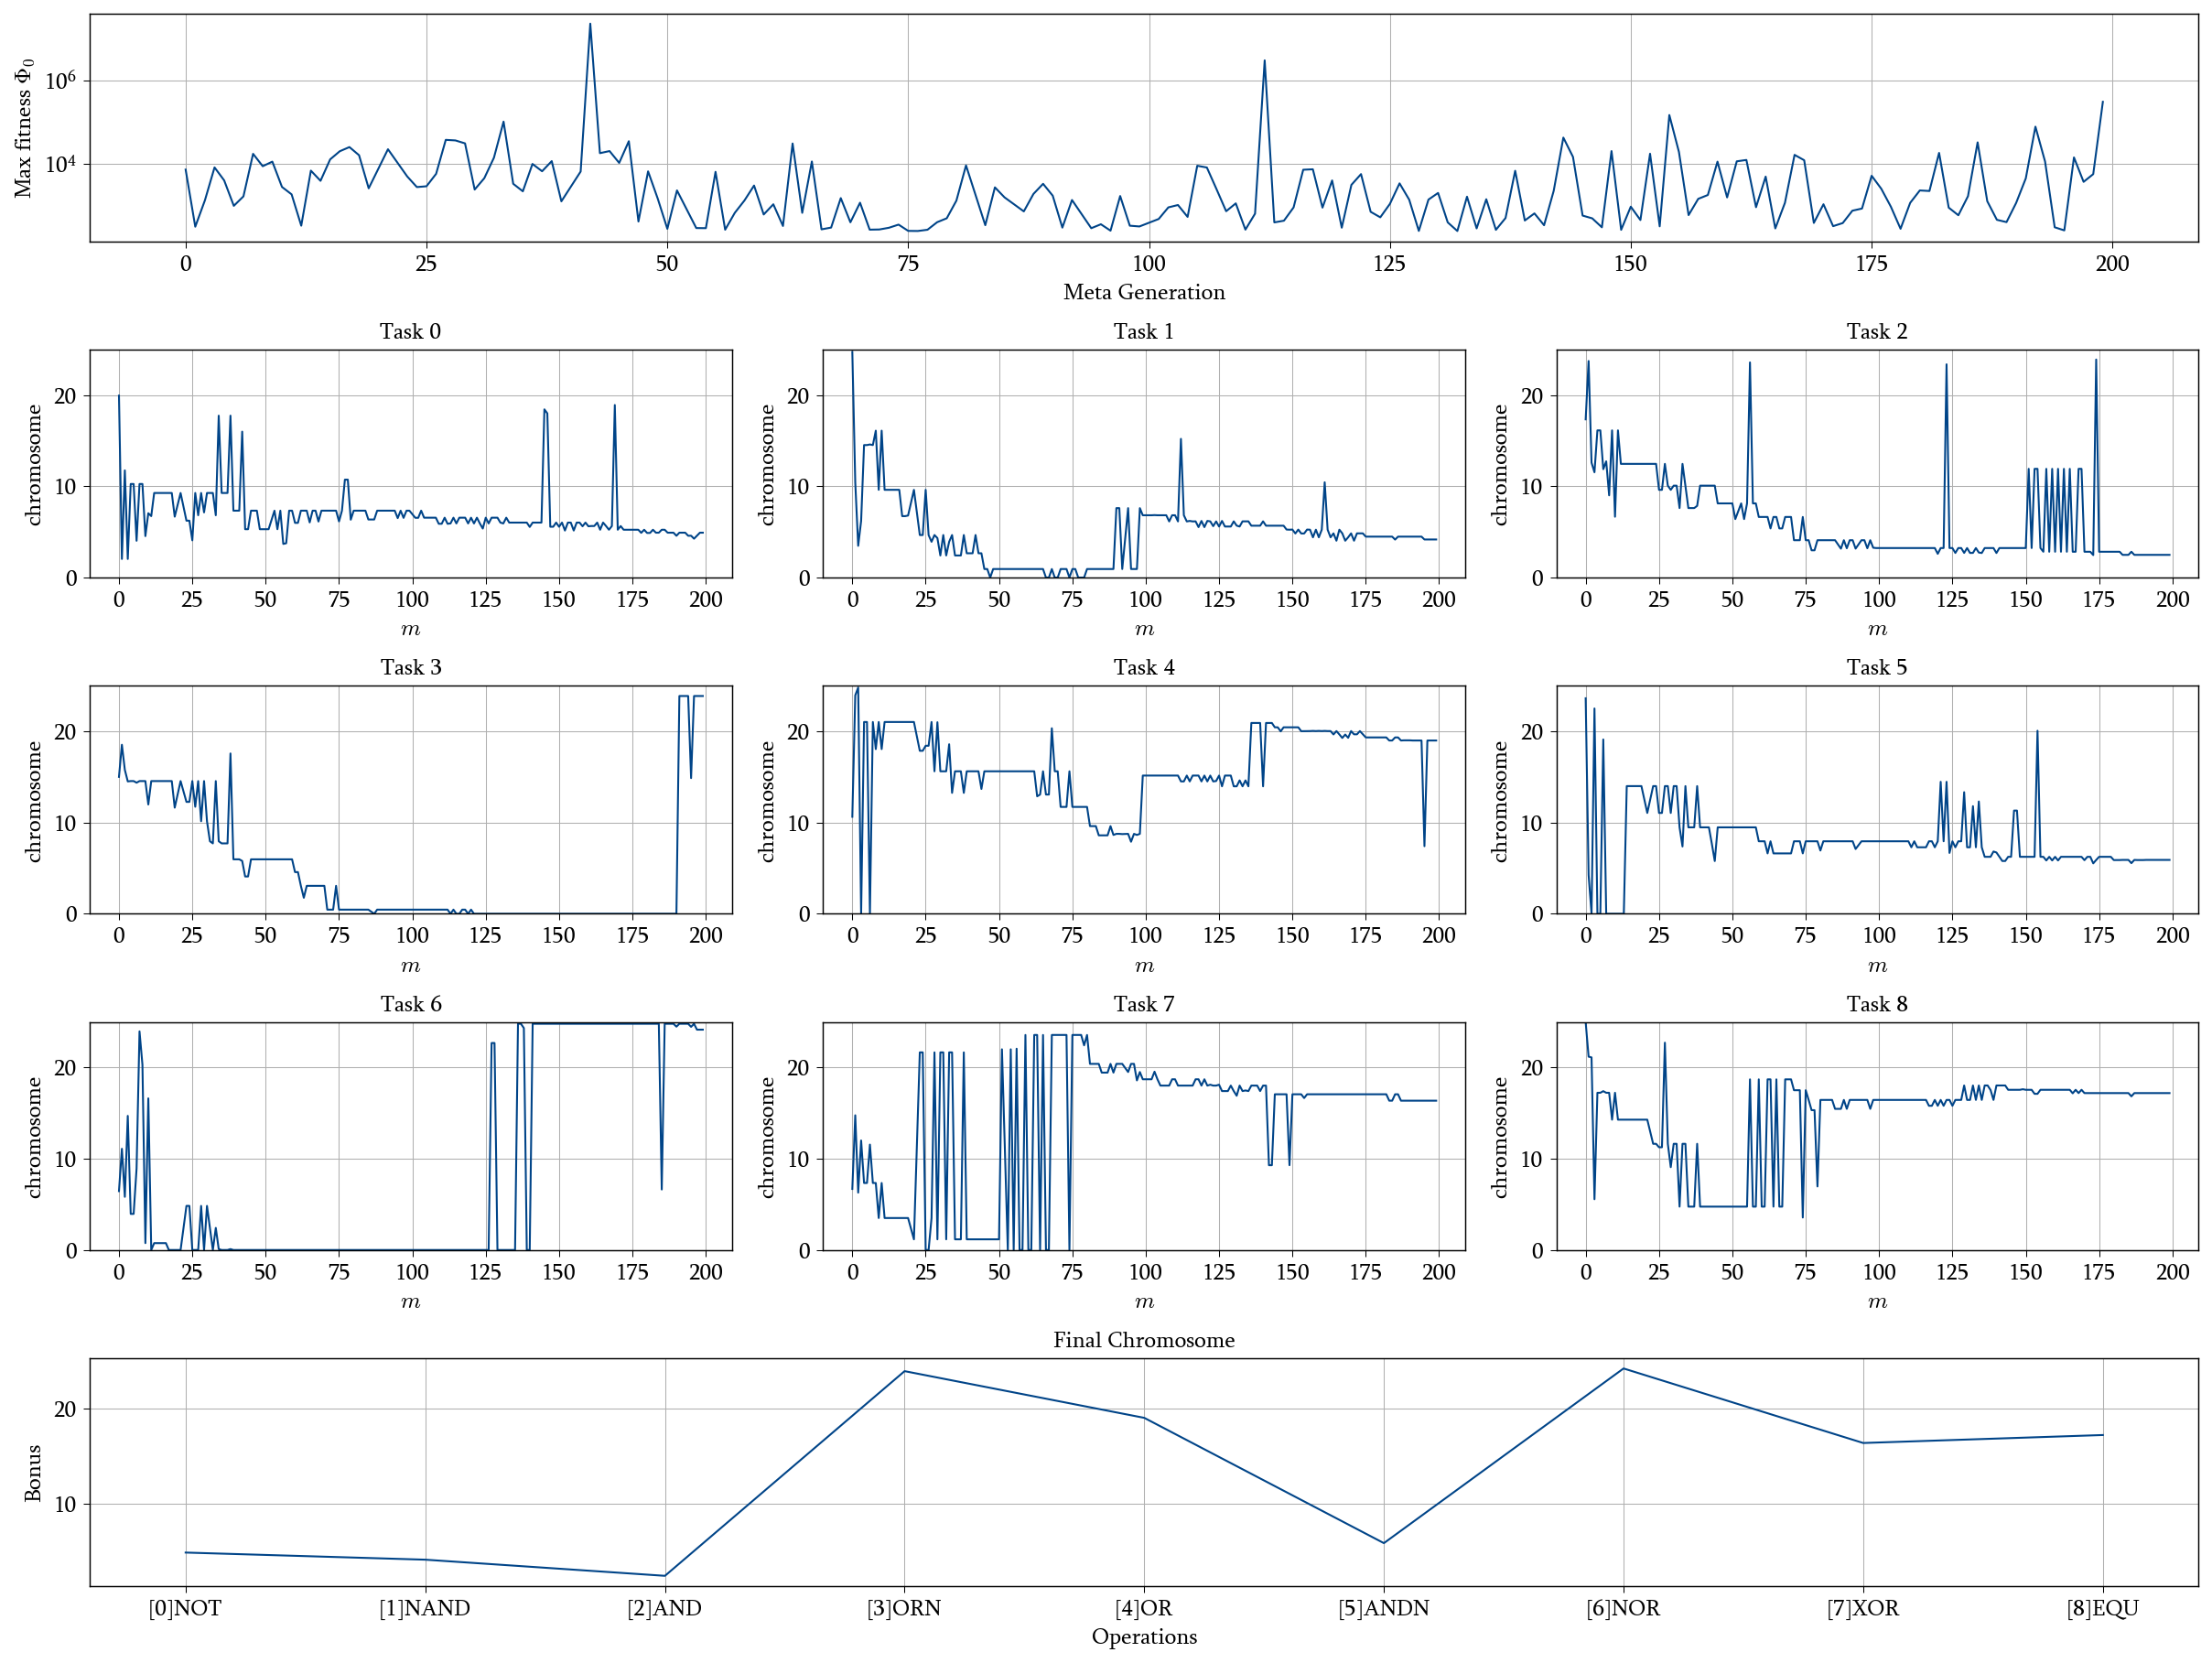

In [412]:
produce_meta_report(run_name="run_02_02")

(m,n)=(0,0): Sum of phi_0:  2.8e+05, Phi_0 at last update 198.72501 
(m,n)=(0,0): Sum of tasks:  2.9e+07,
 [5923059. 6166825.   44842. 6173028. 4284149. 5913516.   37434.       0.
       0.]
(m,n)=(1,0): Sum of phi_0:  3.5e+03, Phi_0 at last update 2.910414 
(m,n)=(1,0): Sum of tasks:  1.1e+07,
 [4.298378e+06 3.360780e+06 2.930000e+02 3.300819e+06 0.000000e+00
 1.830000e+02 0.000000e+00 0.000000e+00 0.000000e+00]
(m,n)=(2,0): Sum of phi_0:  2.4e+03, Phi_0 at last update 5.112115 
(m,n)=(2,0): Sum of tasks:  6.9e+06,
 [4.94538e+06 3.98190e+04 4.08000e+02 9.98808e+05 9.00077e+05 2.78000e+02
 0.00000e+00 0.00000e+00 0.00000e+00]
(m,n)=(3,0): Sum of phi_0:  3.3e+05, Phi_0 at last update 296.982403 
(m,n)=(3,0): Sum of tasks:  2.6e+07,
 [5.262630e+06 5.987775e+06 4.338100e+04 5.977252e+06 4.743415e+06
 4.164074e+06 3.300000e+01 2.900000e+01 0.000000e+00]
(m,n)=(16,0): Sum of phi_0:  1.3e+05, Phi_0 at last update 478.909365 
(m,n)=(16,0): Sum of tasks:  1.7e+07,
 [5106460. 1623427.   42177. 

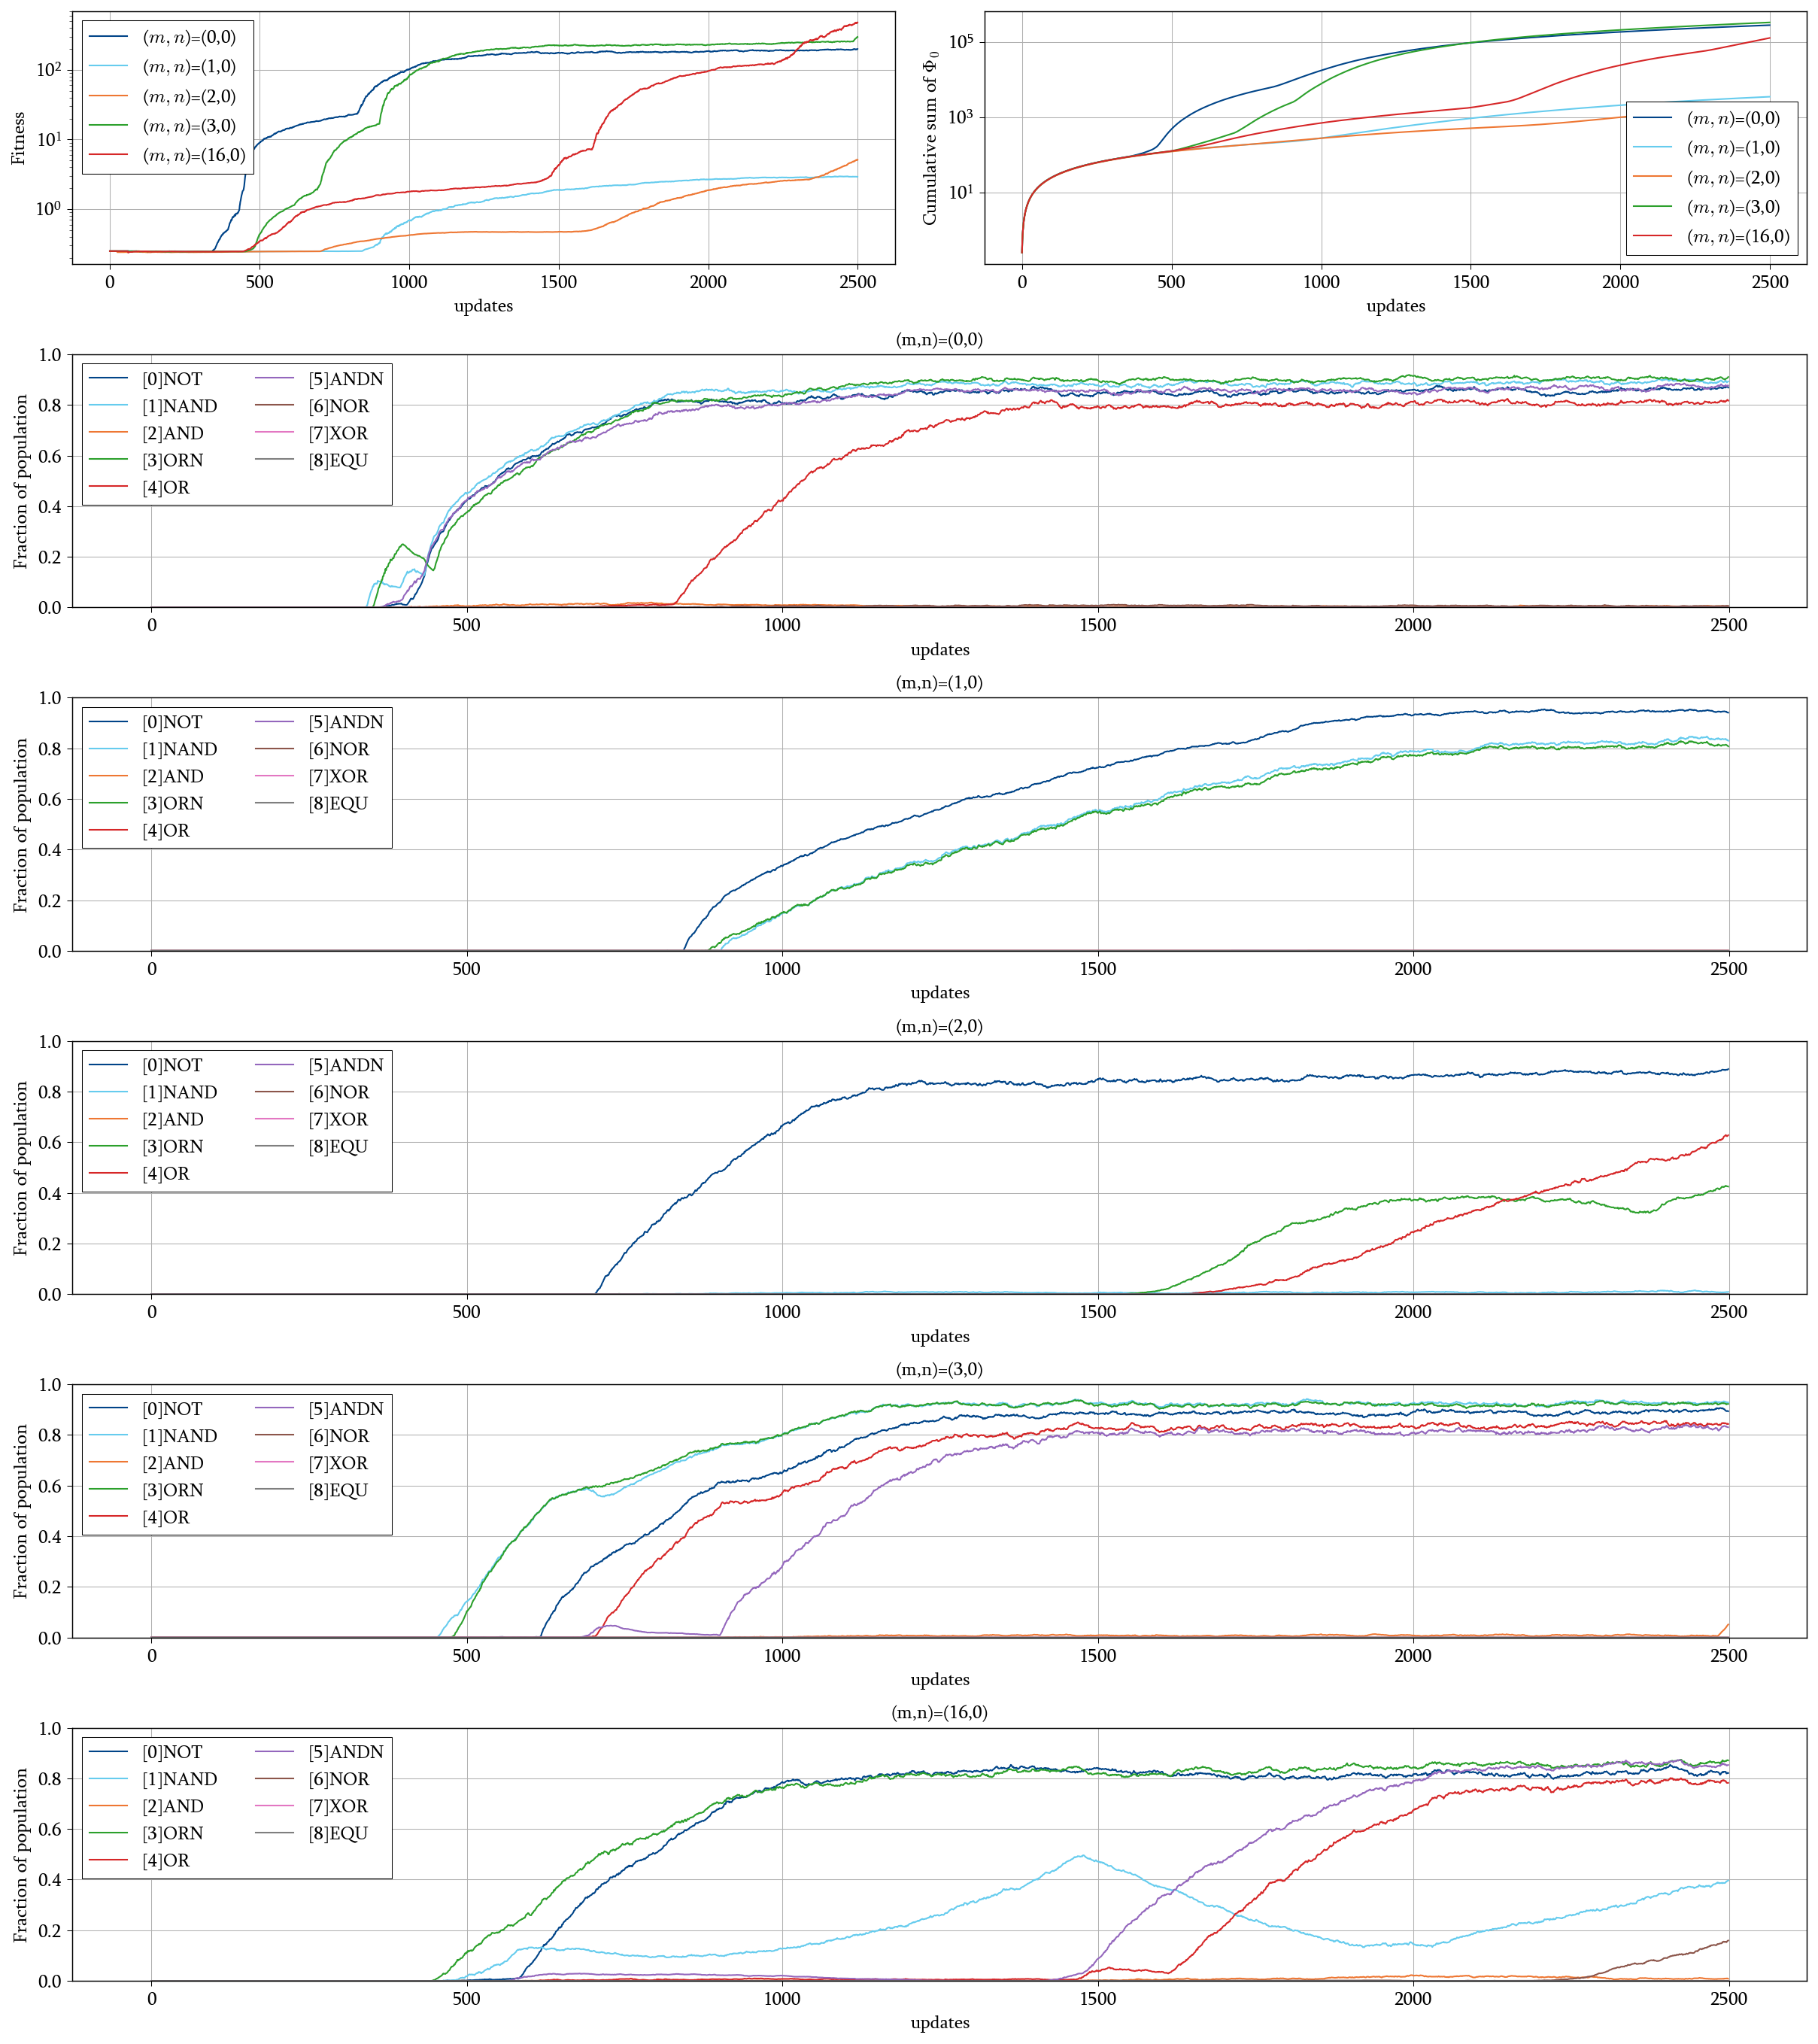

In [415]:
compare_meta_runs(M=[0,1,2,3, 16], N=[0,0,0,0,0])

***** REPORT *****
Settings:


,N,M,U,tournament_probability,crossover_probability,mutation_probability,mutation_probability_constant,mutation_decay,min_mutation_constant,gene_min,...,min_creep,hatPhi_0[0],hatPhi_0[1],hatPhi_0[2],hatPhi_0[3],hatPhi_0[4],hatPhi_0[5],hatPhi_0[6],hatPhi_0[7],hatPhi_0[8]
0,12,40,2500,0.8,0.3,0.333333,3.0,0.95,0.5,0.0,...,0.28,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,5.0


Best fintess per meta generation and the corresponding chromosomes


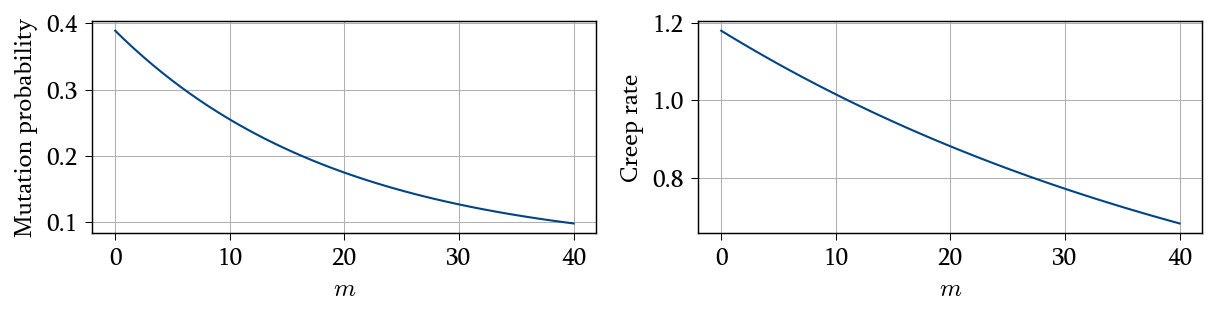

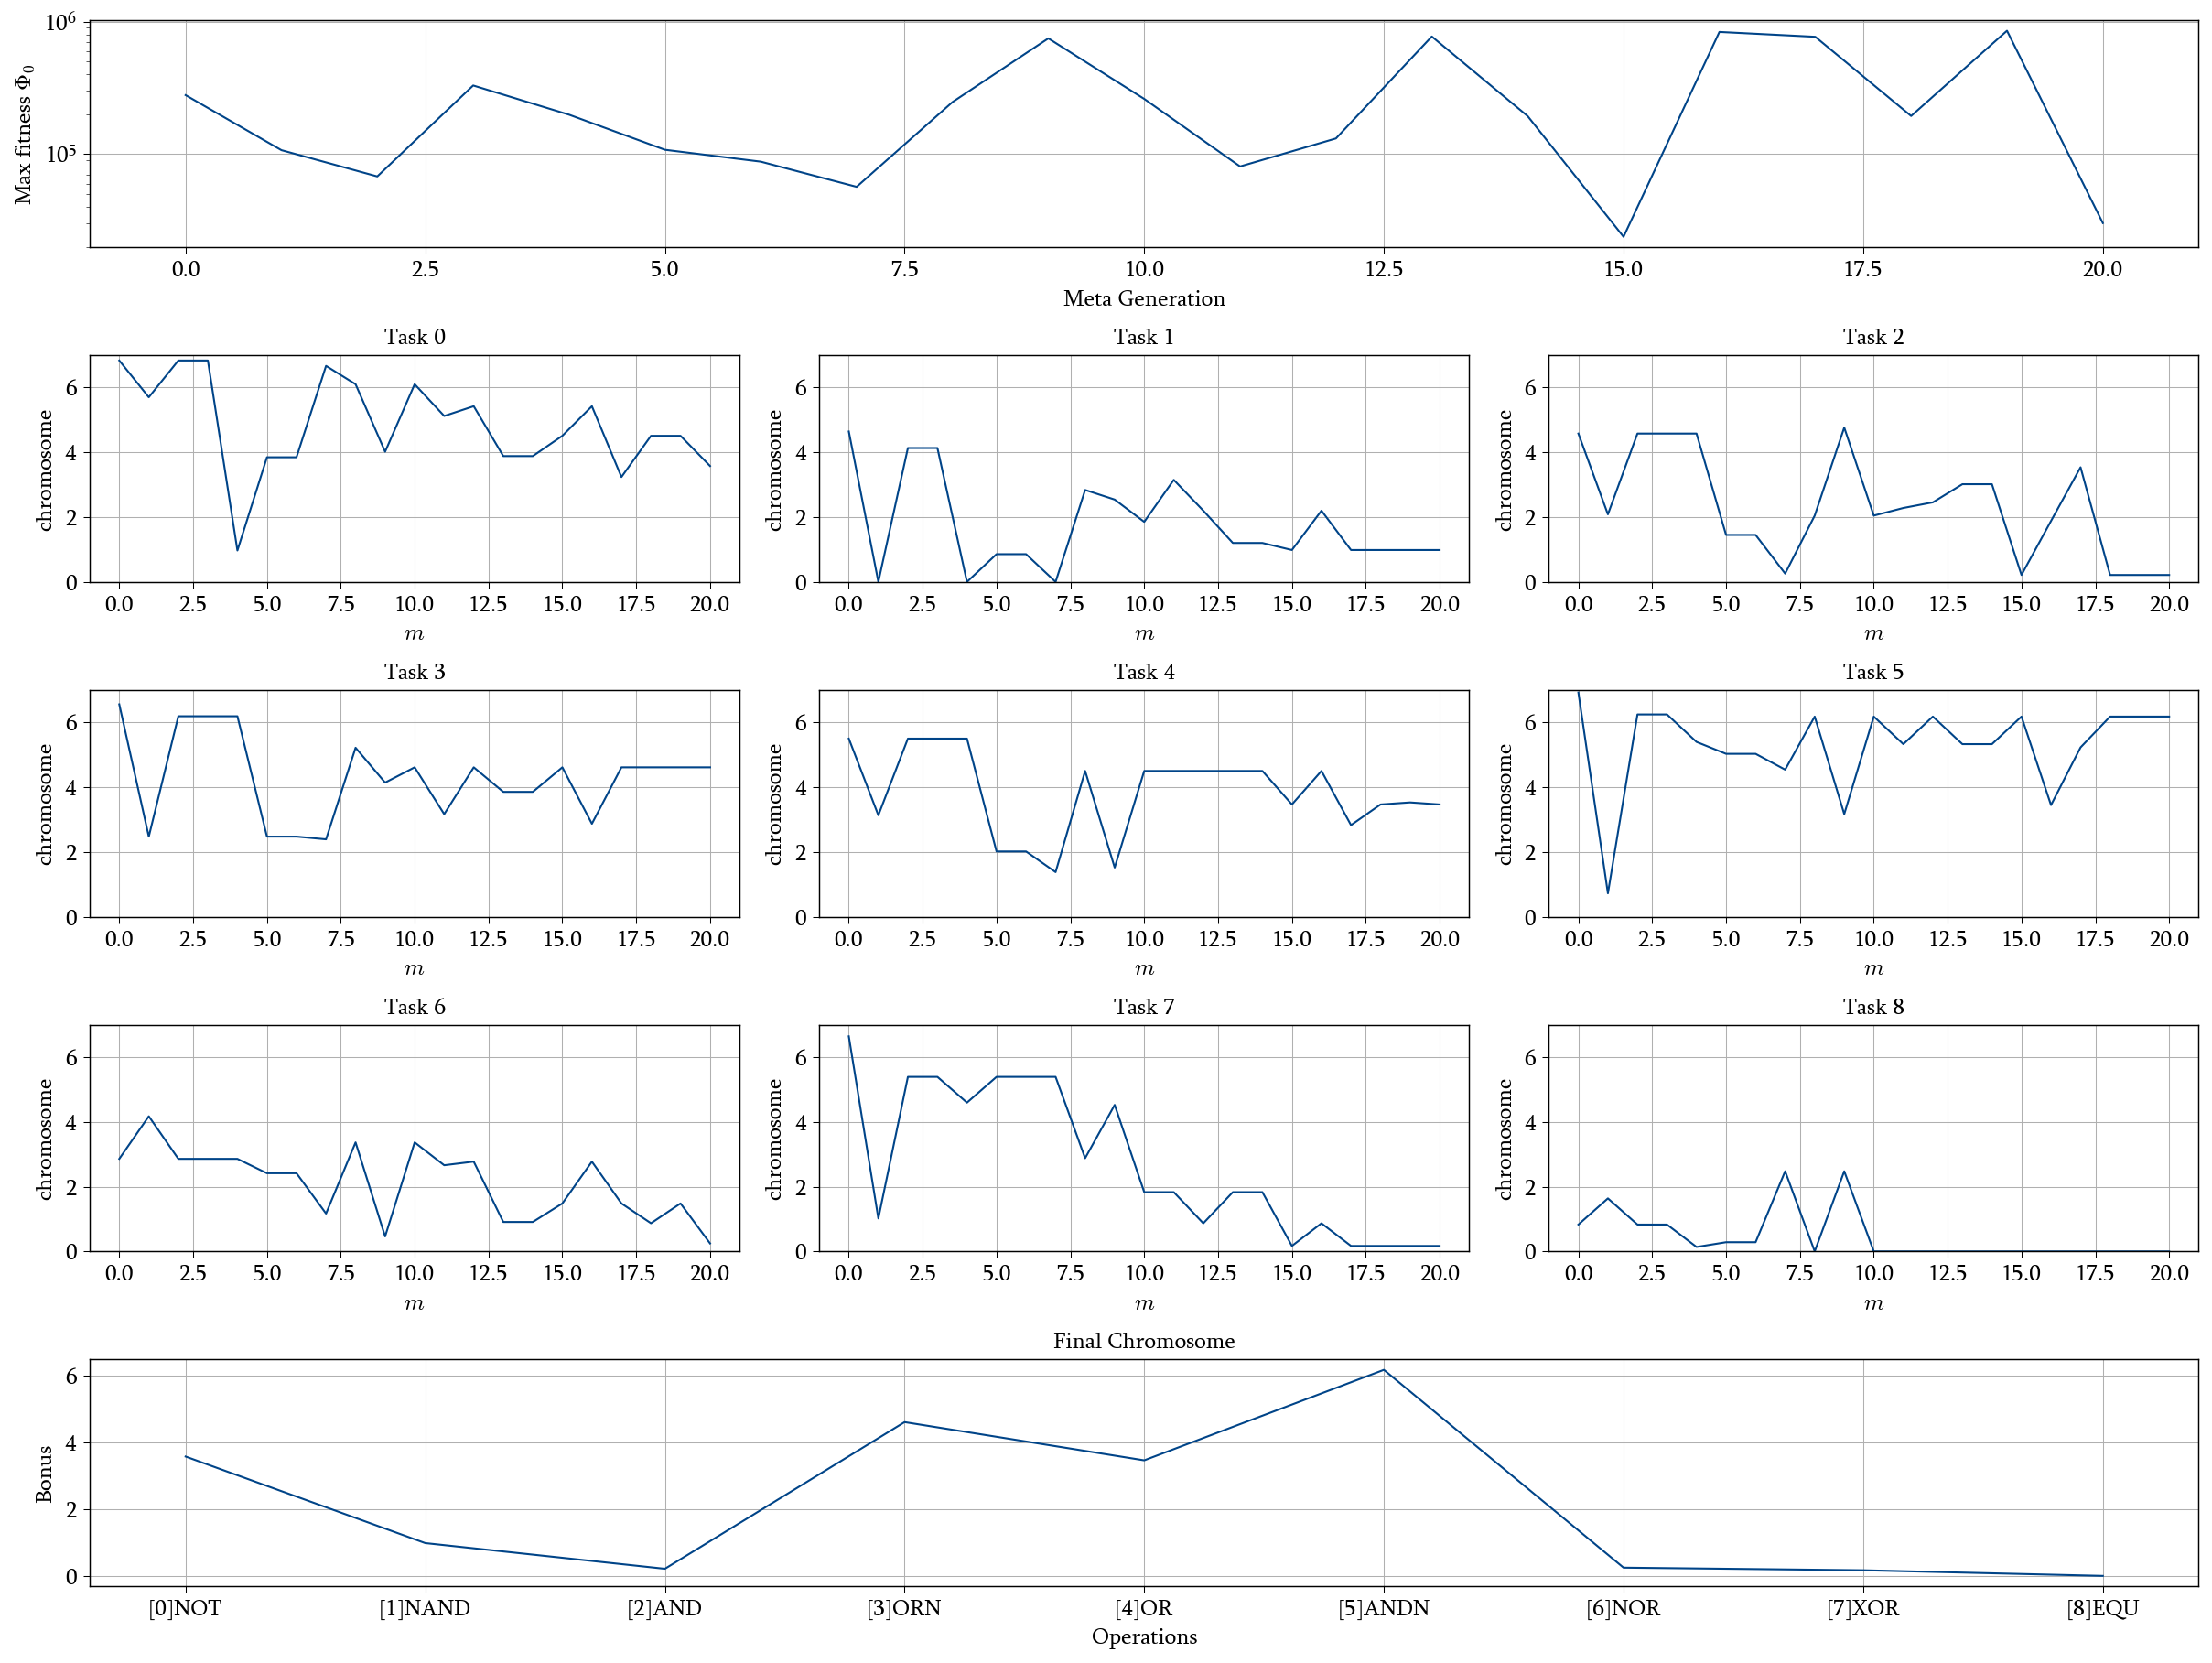

In [417]:
produce_meta_report()